In [1]:
import pandas as pd
import collections
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import scipy.stats as st
from tqdm import tqdm
import itertools
from numpy import exp
from statistics import mean
import scipy.stats as stats
import pickle
from typing import OrderedDict

In [57]:
def manipulate_data(raw, stroke = False):
    '''anchor data header to the marker given'''
    df = raw
    df.drop([1,2], inplace = True)
    if stroke == True:
        subject = ["subject"]
        for i in df.columns[1:]:
            subject.append(i.split("\\")[1]) 

    else:
        subject = [i[0:5] for i in df.columns]
        subject[0] = "subject"
    df.loc[-1] = subject
    videoRecord = []
    for i in df.columns:
        videoRecord.append(i.split("\\")[-1].split(".")[0])
    videoRecord[0] = "record"
    df.loc[-2] = videoRecord
    df = df.sort_index()
    df.reset_index(inplace=True)
    df.drop(columns=["index"], inplace = True)
    df.rename(columns = {df.columns[0] : "video"}, inplace = True)
    df["video"][2] = "markers"
    df["video"][3] = "axis"
    df_transposed = df.T
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed.drop('video', axis = 0, inplace = True)
    marker_list = df_transposed["markers"].unique()
    subject_list = df_transposed["subject"].unique()
    # print(df_transposed)
    # print(subject_list)
    standard_marker_list = ['L_Elbow_JOINT_ANGLE',
        'L_Shoulder_JOINT_ANGLE',
        'L_Wrist_JOINT_ANGLE',
        'R_Elbow_JOINT_ANGLE',
        'R_Shoulder_JOINT_ANGLE',
        'R_Wrist_JOINT_ANGLE']
    discard_index_list = []
    for i in marker_list:
        if i not in standard_marker_list:
            discard_index_list.extend(df_transposed[df_transposed['markers'] == i].index)
    df_transposed.drop(discard_index_list, axis = 0, inplace = True)
    discard_index_list = []
    # print(df_transposed)
    if stroke == True:
        pass
    else:
        toBeExcluded = []
        for subject in subject_list:
            for i in df_transposed["record"][df_transposed["subject"] == subject].unique():
                if len(df_transposed["markers"][(df_transposed["subject"] == subject) & (df_transposed["record"] == i)].unique()) != len(standard_marker_list):
                    toBeExcluded.append(i)
        for records in toBeExcluded:
            discard_index_list.extend(df_transposed[df_transposed["record"] == records].index)
    if len(discard_index_list) != 0:
        df_transposed.drop(discard_index_list, axis = 0, inplace = True)
    DICT_repetition = collections.defaultdict()
    for subject in subject_list:
        repetition = int(sum((df_transposed["markers"] == 'L_Elbow_JOINT_ANGLE') & (df_transposed["subject"] == subject)) / 3)
        # repetition = sum((df_transposed["markers"] == marker) & (df_transposed["subject"] == subject)) / 3

        DICT_repetition[subject] = repetition

    subject_marker_dict = collections.defaultdict()
    repetition_list = []
    for subject in subject_list:
        subject_marker_list = df_transposed[df_transposed["subject"] == subject]["markers"].unique()
        subject_marker_dict[subject] = subject_marker_list
        # print(subject_marker_list)
        for i in range(len(subject_marker_list)):
            for j in range(DICT_repetition[subject]):
                repetition_list.extend([j + 1, j + 1, j + 1])
    df_transposed.insert(3, 'repetition', repetition_list)
    subject_list = df_transposed["subject"].unique()




    return df_transposed, subject_list, subject_marker_dict, DICT_repetition


In [433]:
df = normative_mouth_R
# df.drop([1,2], inplace = True)
# if stroke == True:
#     subject = ["subject"]
#     for i in df.columns[1:]:
#         subject.append(i.split("\\")[1]) 

# else:
# subject = [i[0:5] for i in df.columns]
# subject[0] = "subject"
# df.loc[-1] = subject
# videoRecord = []
# for i in df.columns:
#     videoRecord.append(i.split("\\")[-1].split(".")[0])
# videoRecord[0] = "record"
# df.loc[-2] = videoRecord
# df = df.sort_index()
# df.reset_index(inplace=True)
# df.drop(columns=["index"], inplace = True)
# df.rename(columns = {df.columns[0] : "video"}, inplace = True)
# df["video"][2] = "markers"
# df["video"][3] = "axis"
# df_transposed = df.T
# df_transposed.columns = df_transposed.iloc[0]
# df_transposed.drop('video', axis = 0, inplace = True)
# marker_list = df_transposed["markers"].unique()
# subject_list = df_transposed["subject"].unique()
# standard_marker_list = ['L_Elbow_JOINT_ANGLE',
#     'L_Shoulder_JOINT_ANGLE',
#     'L_Wrist_JOINT_ANGLE',
#     'R_Elbow_JOINT_ANGLE',
#     'R_Shoulder_JOINT_ANGLE',
#     'R_Wrist_JOINT_ANGLE']
# discard_index_list = []
# for i in marker_list:
#     if i not in standard_marker_list:
#         discard_index_list.extend(df_transposed[df_transposed['markers'] == i].index)
# df_transposed.drop(discard_index_list, axis = 0, inplace = True)
discard_index_list = []
# if stroke == True:
#     pass
# else:
# toBeExcluded = []
# for subject in subject_list:
#     for i in df_transposed["record"][df_transposed["subject"] == subject].unique():
#         if len(df_transposed["markers"][(df_transposed["subject"] == subject) & (df_transposed["record"] == i)].unique()) != len(standard_marker_list):
#             toBeExcluded.append(i)
# for records in toBeExcluded:
#     discard_index_list.extend(df_transposed[df_transposed["record"] == records].index)
# if len(discard_index_list) != 0:
#     df_transposed.drop(discard_index_list, axis = 0, inplace = True)
df_transposed
# discard_index_list
# df_transposed
# DICT_repetition = collections.defaultdict()
# for subject in subject_list:
#     repetition = int(sum((df_transposed["markers"] == 'L_Elbow_JOINT_ANGLE') & (df_transposed["subject"] == subject)) / 3)
#     # repetition = sum((df_transposed["markers"] == marker) & (df_transposed["subject"] == subject)) / 3

#     DICT_repetition[subject] = repetition

# subject_marker_dict = collections.defaultdict()
# repetition_list = []
# for subject in subject_list:
#     subject_marker_list = df_transposed[df_transposed["subject"] == subject]["markers"].unique()
#     subject_marker_dict[subject] = subject_marker_list
#     # print(subject_marker_list)
#     for i in range(len(subject_marker_list)):
#         for j in range(DICT_repetition[subject]):
#             repetition_list.extend([j + 1, j + 1, j + 1])
# df_transposed.insert(3, 'repetition', repetition_list)

video,record,subject,markers,axis,NaN,ITEM,1,2,3,4,...,291,292,293,294,295,296,297,298,299,300
SN093.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\40\[dynamic]SN093_0010_mouth_R01.c3d,[dynamic]SN093_0010_mouth_R01,SN093,L_Elbow_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,X,57.322464,57.321255,57.320015,57.318756,...,56.350647,56.353794,56.357761,56.36253,56.368073,56.374325,56.381203,56.388626,56.396507,56.404755
SN093.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\40\[dynamic]SN093_0010_mouth_R01.c3d.1,[dynamic]SN093_0010_mouth_R01,SN093,L_Elbow_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Y,24.849430,24.852001,24.854765,24.857653,...,24.876938,24.884897,24.891729,24.897408,24.901939,24.905388,24.907822,24.909311,24.909954,24.909842
SN093.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\40\[dynamic]SN093_0010_mouth_R01.c3d.2,[dynamic]SN093_0010_mouth_R01,SN093,L_Elbow_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Z,157.353500,157.356430,157.359482,157.362396,...,157.142288,157.145889,157.148682,157.150635,157.151749,157.152069,157.151596,157.150391,157.148468,157.145859
SN093.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\40\[dynamic]SN093_0010_mouth_R01.c3d.3,[dynamic]SN093_0010_mouth_R01,SN093,L_Elbow_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,X,57.210487,57.210701,57.210926,57.211140,...,55.499966,55.502422,55.505997,55.510674,55.516438,55.523277,55.531212,55.54026,55.550407,55.561626
SN093.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\40\[dynamic]SN093_0010_mouth_R01.c3d.4,[dynamic]SN093_0010_mouth_R01,SN093,L_Elbow_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Y,24.869936,24.868725,24.867592,24.866560,...,24.585825,24.607306,24.629126,24.651127,24.673124,24.694921,24.716278,24.736958,24.7568,24.775675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN400.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\210\[dynamic]SN400_0020_mouth_R01.c3d.103,[dynamic]SN400_0020_mouth_R01,SN400,R_Wrist_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Y,-3.449689,-3.448029,-3.446147,-3.444158,...,-9.781804,-9.774602,-9.765183,-9.753839,-9.740819,-9.726358,-9.710683,-9.69403,-9.676668,-9.65896
SN400.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\210\[dynamic]SN400_0020_mouth_R01.c3d.104,[dynamic]SN400_0020_mouth_R01,SN400,R_Wrist_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Z,3.794816,3.797519,3.798967,3.799103,...,-16.088793,-16.086039,-16.088003,-16.093967,-16.103416,-16.115969,-16.13139,-16.149307,-16.169138,-16.190184
SN400.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\210\[dynamic]SN400_0020_mouth_R01.c3d.105,[dynamic]SN400_0020_mouth_R01,SN400,R_Wrist_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,X,-30.881399,-30.880638,-30.879150,-30.876883,...,-27.58736,-27.594843,-27.601591,-27.606771,-27.609797,-27.610336,-27.60836,-27.604076,-27.597971,-27.590761
SN400.cmz\D:\HDD_Software\data\Projects\BCI_grp4\For Processing\210\[dynamic]SN400_0020_mouth_R01.c3d.106,[dynamic]SN400_0020_mouth_R01,SN400,R_Wrist_JOINT_ANGLE,LINK_MODEL_BASED,ORIGINAL,Y,-2.828643,-2.827687,-2.826131,-2.823996,...,-10.914941,-10.921537,-10.93104,-10.942938,-10.956542,-10.970998,-10.985257,-10.998154,-11.008419,-11.014827


In [58]:
def get_coordinates_dict(data, data_point, point_to_analyse, subject_list, repetition_dict, subject_marker_dict):
    ''' 
    first output: separate out the coordinates for each repetition for each subject;
    second output: calculate out the mean trajectory;
    third output: total number of repetitions considered
    (not yet in use)
    '''
    # separate out the coordinates for each repetition for each subject
    subject_coordinates_repetition_dict = collections.defaultdict()
    coordinates_array = None
    n_sample = 0
    for subject in subject_list:
        # only if the subject has the point to analyse, otherwise, skipped
        if point_to_analyse in subject_marker_dict[subject]:
            n_sample = n_sample + repetition_dict[subject]

            for i in range(repetition_dict[subject]):
                x_data, y_data = np.array(data[(data["subject"] == subject) & (data["markers"] == point_to_analyse) & (data["axis"] == "X") & (data["repetition"] == i + 1)].drop(columns = ["subject", "markers", "repetition", "axis"]).T).astype(float), np.array(data[(data["subject"] == subject) & (data["markers"] == point_to_analyse) & (data["axis"] == "Y") & (data["repetition"] == i + 1)].drop(columns = ["subject", "markers", "repetition", "axis"]).T).astype(float)
                a, b = x_data[0], y_data[0]
                x_data = x_data - a
                y_data = y_data - b
                coordinates = np.concatenate((x_data, y_data), axis = 1)
                if coordinates_array is None:
                    coordinates_array = coordinates
                elif  coordinates_array is not None:
                    coordinates_array = np.append(coordinates_array, coordinates)
            
            # compile into each repetition for each subject
            subject_coordinates_repetition_dict[subject] = coordinates_array.reshape(-1, data_point,2)
    
    # calculate the trajectory mean
    coordinates_mean = np.mean(np.concatenate(list(subject_coordinates_repetition_dict.values())), axis = 0)

    return subject_coordinates_repetition_dict, coordinates_mean, n_sample

In [45]:
subject_list

array(['BCI002'], dtype=object)

In [56]:
# vert_R_df, result_towel_vert_R, norm_dist_towel_vert_R = main(normative_towel_vert_R, stroke_towel_vert_R, TOWEL_vertFold, analyse_dict_R, ROM_dict, data_point, 'towel vert R')
# vert_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\towel\RightJA_2Pick1_Bwd.txt", sep = '\t')

vert_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\towel\RightJA_2Pick1_Bwd.txt", sep = '\t')

data, subject_list, subject_marker_dict, repetition_dict = manipulate_data(vert_R, stroke = False)

# print("Starting for Task:", name)
total_index = 0
for key in TOWEL_vertFold.keys():
    total_index = total_index + len(TOWEL_vertFold[key])*len(analyse_dict_R[key])


# consolidate end results
feature_dict = get_feature_dict(analyse_dict_R, TOWEL_vertFold)
result = pd.DataFrame(columns = ['Joint Angle', 'Feature', 'Stroke Patient Score', 'Normative Confidence Interval'], index = [i for i in range(total_index)])
rotation = {"X":"Flexion/Extension", "Y":"Abduction/Adduction", "Z":"External/Internal Rotation"}
current_index = -1


normal_dist_data = collections.defaultdict()


for each_feature in feature_dict.keys():
    print("joint angle:", each_feature)
    for each_axis in feature_dict[each_feature]:
        print("axis: ", each_axis)
        normative_JA, normative_JA_mean, normative_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, subject_list, repetition_dict, subject_marker_dict)
        for subject in tqdm(subject_list):
            individual_subject_list = [subject]
            # bootstrap_subject_list = [ x for x in subject_list if x != subject]
            # bootstrap_JA, bootstrap_JA_mean, bootstrap_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, bootstrap_subject_list, repetition_dict, subject_marker_dict, here= True)
            individual_JA, individual_JA_mean, individual_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, individual_subject_list, repetition_dict, subject_marker_dict)
                



C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\730188192.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

joint angle: R_Shoulder_JOINT_ANGLE
axis:  X


100%|██████████| 70/70 [00:01<00:00, 69.87it/s]


joint angle: R_Elbow_JOINT_ANGLE
axis:  X


100%|██████████| 70/70 [00:01<00:00, 53.02it/s]


joint angle: R_Wrist_JOINT_ANGLE
axis:  X


100%|██████████| 70/70 [00:01<00:00, 46.27it/s]


In [60]:
def get_joint_angle_dict(data, data_point, JA_to_analyse, axis_to_analyse, subject_list, repetition_dict, subject_marker_dict):
    ''' 
    first output: separate out the JA for each repetition for each subject;
    second output: calculate out the mean JA trajectory;
    third output: total number of repetitions considered
    '''
    # separate out the JA for each repetition for each subject
    subject_JA_repetition_dict = collections.defaultdict()
    JA_array = None
    n_sample = 0
    for subject in subject_list:
        if JA_to_analyse in subject_marker_dict[subject]:
            n_sample = n_sample + repetition_dict[subject]

            for i in range(repetition_dict[subject]):
                JA = np.array(data[(data["subject"] == subject) & (data["markers"] == JA_to_analyse) & (data["axis"] == axis_to_analyse) & (data["repetition"] == i + 1)].drop(columns = ["subject", "markers", "repetition", "axis", "record"]).T).astype(float)
                # for x-coordinates(time)
                time = np.array([ int(i) for i in range(JA.shape[0])]).reshape(JA.shape[0],-1)
                time_series_coordinates = np.concatenate((time, JA), axis = 1)
                if JA_array is None:
                    JA_array = time_series_coordinates
                elif  JA_array is not None:
                    JA_array = np.append(JA_array, time_series_coordinates)
                
            # compile into each repetition for each subject
            subject_JA_repetition_dict[subject] = JA_array.reshape(-1, data_point, 2)
    # calculate the trajectory mean
    # try:
    JA_mean = np.mean(np.concatenate(list(subject_JA_repetition_dict.values())), axis = 0)
    # except:
    #     print(subject_list)
    #     print(subject_JA_repetition_dict)

    # print(JA_mean)

    return subject_JA_repetition_dict, JA_mean, n_sample


In [61]:
def generate_norm_dist(normal_dist_data, show_graph = False):
    ''' to generate normal distribution for each point to analyse and return the confidence interval of 95%, show graph if needed'''
    confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))
    if show_graph:
        count, bins, ignored = plt.hist(list(normal_dist_data), len(normal_dist_data))
        plt.show()
    return confidence

def generate_score(normative_mean, stroke_mean, plot_graph = False):
    '''calculate dtw score between two mean graph, plot graph if needed to see the time warping relation'''
    score = dtw.distance(normative_mean[:,1], stroke_mean[:,1])
    if plot_graph:
        fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all', sharey='all')
        path = dtw.warping_path(normative_mean[:,1], stroke_mean[:,1])
        dtwvis.plot_warping(normative_mean[:,1], stroke_mean[:,1], path, fig = fig, axs = axs)
        plt.show()
    return score

In [62]:
def get_feature_dict(analyse_dict, axis_list):
    feature_dict = collections.defaultdict()
    for key in analyse_dict.keys():
        try:
            for i in analyse_dict[key]:
                feature_dict[i] = axis_list[key]
        except:
            continue
    return feature_dict

In [63]:
def upper_threshold(result_df):
    result_list = []
    for index in range(len(result_df)):
        if (int(result_df["Stroke Patient Score"][index]) > result_df["Normative Confidence Interval"][index][0]) == True and (int(result_df["Stroke Patient Score"][index]) < result_df["Normative Confidence Interval"][index][1]) == True:
            # result_df["Drop (Upper threshold)"][index] = 1
            result_list.append(1)
        else:
            # result_df["Drop (Upper threshold)"][index] = 0
            result_list.append(0)

    result_df['Drop (Upper threshold)'] = result_list
    return result_df

def get_trial_ROM(df, feature_dict, first_result):
    df['feature'] = np.array(df["markers"] + '_'+ df["axis"])
    features_list = [i+'_'+j for i, k in feature_dict.items() for j in k]
    relevant_df = df[df["feature"].isin(features_list)]
    trial_rom_list = []
    for i in range(len(relevant_df)):
        trial_rom_list.append(max([float(k) for k in relevant_df.iloc[i,4:-1]]) - min([float(k) for k in relevant_df.iloc[i,4:-1]]))
        # print(trial_ROM)
    # test.iloc[:,4:-1]
    relevant_df["trial ROM"] = trial_rom_list
    average_list = collections.defaultdict()
    for feature in features_list:
        average_list[feature] = mean(relevant_df["trial ROM"][relevant_df["feature"] == feature])
    resorted_average_list = []
    for i in range(len(first_result)):
        if first_result["Feature"][i] == "Flexion/Extension":
            axis = "X"
        if first_result["Feature"][i] == "Abduction/Adduction":
            axis = "Y"
        if first_result["Feature"][i] == "External/Internal Rotation":
            axis = "Z"
        resorted_average_list.append(average_list[first_result["Joint Angle"][i] + '_' + axis])
    first_result["Trial ROM"] = resorted_average_list
    return relevant_df, features_list, first_result
    return df

def get_significance_vector(result_table, feature_dict, analyse_dict, ROM_dict):
    significancy_list = []
    rom_list = []
    total_calculation = []
    result_table = result_table.reset_index()
    for index in range(len(result_table)):
        for each_axis in feature_dict[result_table["Joint Angle"][index]]:
            for i, k in analyse_dict.items():
                if result_table["Joint Angle"][index] in k:
                    rangeOfMotion = tuple((i, each_axis))
                    break
        rom_list.append(ROM_dict[rangeOfMotion])
        if int(result_table["Drop (Upper threshold)"][index]) == 0:
            significancy = (result_table["Trial ROM"][index]) / (int(ROM_dict[rangeOfMotion][1]) - int(ROM_dict[rangeOfMotion][0]))
            significancy_list.append(float(significancy))
        else:
            significancy_list.append(0)
    # print(significancy_list)
    result_table["ROM"] = rom_list
    result_table["weight"] = significancy_list

    return result_table

In [64]:
ROM_dict = collections.defaultdict()
ROM_dict[('elbow', 'X')] = tuple((0,140))
ROM_dict['elbow', 'Z'] = tuple((-80, 80))
ROM_dict[('shoulder', 'X')] = tuple((-50, 180))
ROM_dict[('shoulder', 'Y')] = tuple((-180, 50))
ROM_dict[('shoulder', 'Z')]= tuple((-90, 90))
ROM_dict[('wrist', 'X')] = tuple((-60, 60))
# ROM_dict[('wrist', 'Z')] = tuple((-20, 20))
data_point = 300

# inputs
TOWEL_vertFold = {"shoulder":["X"], "elbow":["X"], "wrist":["X"]}
TOWEL_horiFold = {"shoulder":["X", "Y"], "elbow":["X"], "wrist":["X"]}
GRASP = {"shoulder":["X"], "elbow":["X"], "wrist":["X"]}
LATERAL = {"shoulder":["X", "Y"], "elbow":["X"]}
MOUTH = {"shoulder":["X", "Y"], "elbow":["X", "Z"], "wrist":["X"]} 
KEY = {"shoulder":["X", "Y"], "elbow":["X", "Z"]}

analyse_dict_L = {"shoulder": ["L_Shoulder_JOINT_ANGLE"], "elbow": ["L_Elbow_JOINT_ANGLE"], "wrist": ["L_Wrist_JOINT_ANGLE"]}
analyse_dict_R = {"shoulder": ["R_Shoulder_JOINT_ANGLE"], "elbow": ["R_Elbow_JOINT_ANGLE"], "wrist": ["R_Wrist_JOINT_ANGLE"]}



C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2696310913.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: towel vert R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:34<00:00,  1.35s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


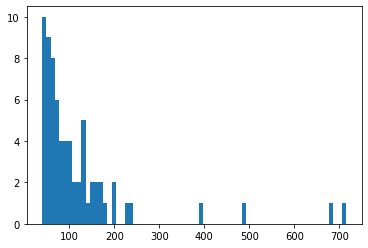

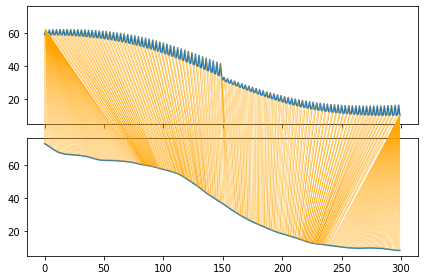

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:39<00:00,  1.41s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


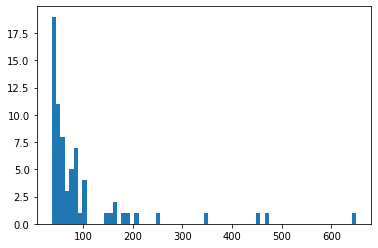

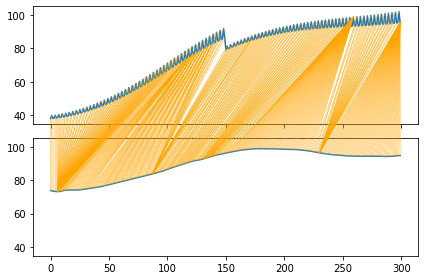

joint angle: R_Wrist_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:44<00:00,  1.50s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


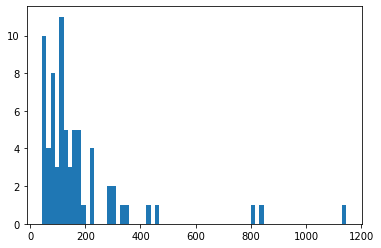

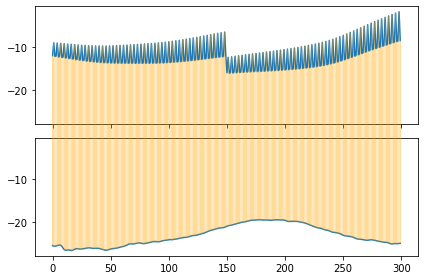

In [65]:
normative_towel_vert_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\towel\RightJA_2Pick1_Bwd.txt", sep = '\t')
stroke_towel_vert_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\towel\RightJA_2Pick1_Bwd.txt", sep = '\t')


towelvert_R_df, result_towel_vert_R, norm_dist_towel_vert_R = main(normative_towel_vert_R, stroke_towel_vert_R, TOWEL_vertFold, analyse_dict_R, ROM_dict, data_point, 'towel vert R')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\1542439441.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: towel hori R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [00:59<00:00,  1.09it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


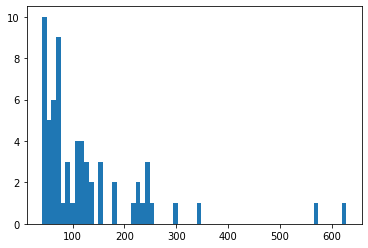

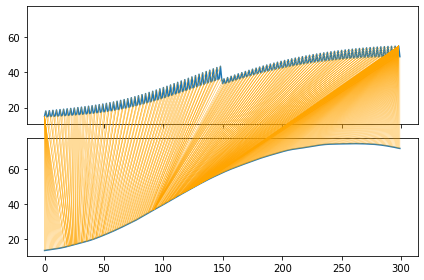

axis: Y


100%|██████████| 65/65 [01:00<00:00,  1.08it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


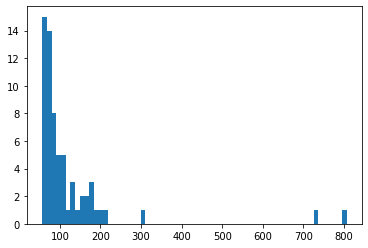

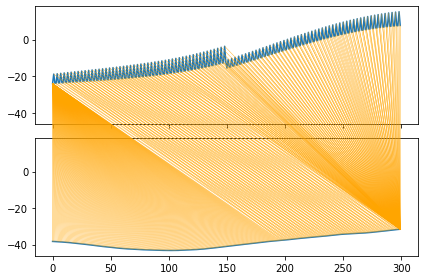

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [00:58<00:00,  1.11it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


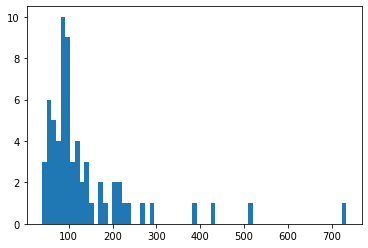

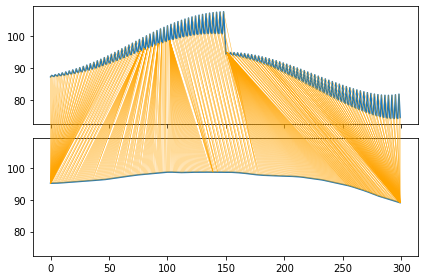

joint angle: R_Wrist_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [00:59<00:00,  1.10it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


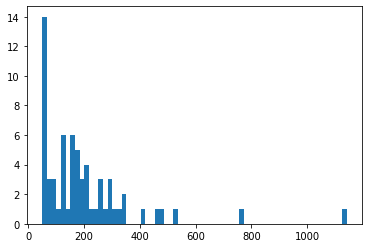

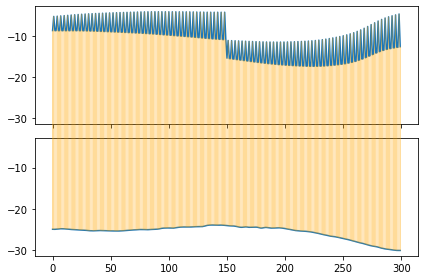

In [98]:
normative_towel_hori_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\towel\RightJA_4Pick2_Cross.txt", sep = '\t')
stroke_towel_hori_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\RightJA_4Pick2_Cross.txt", sep = '\t')

towelhori_R_df, result_towel_hori_R, norm_dist_towel_hori_R = main(normative_towel_hori_R, stroke_towel_hori_R, TOWEL_horiFold, analyse_dict_R, ROM_dict, data_point, 'towel hori R')



C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\3057551536.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: grasp R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:20<00:00,  1.15s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


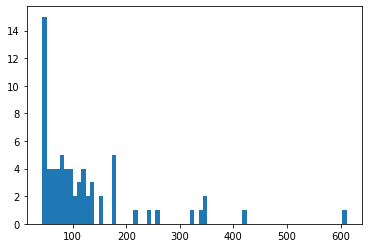

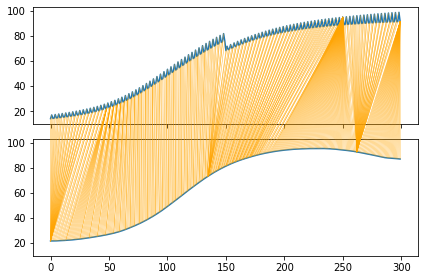

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:22<00:00,  1.18s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


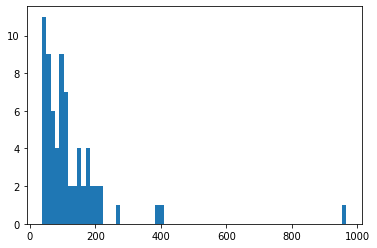

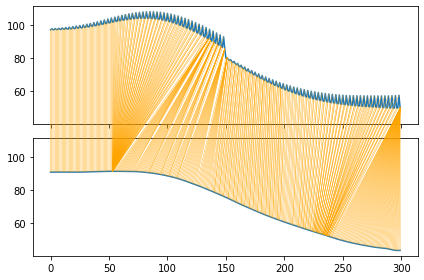

joint angle: R_Wrist_JOINT_ANGLE
axis: X


100%|██████████| 70/70 [01:19<00:00,  1.14s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


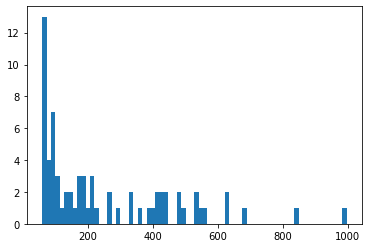

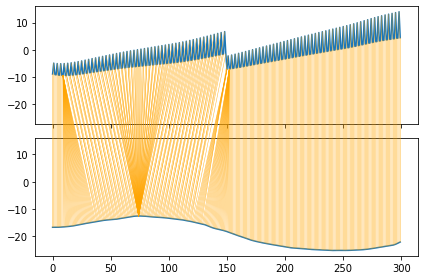

In [99]:
normative_grasp_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\grasp\RightJA_2Block_Shelf.txt", sep = '\t')
stroke_grasp_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\RightJA_2Block_Shelf.txt", sep = '\t')

grasp_R_df, result_grasp_R, norm_dist_grasp_R = main(normative_grasp_R, stroke_grasp_R, GRASP, analyse_dict_R, ROM_dict, data_point, 'grasp R')



C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\3635997367.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: lateral R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 71/71 [1:32:14<00:00, 77.95s/it]     
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


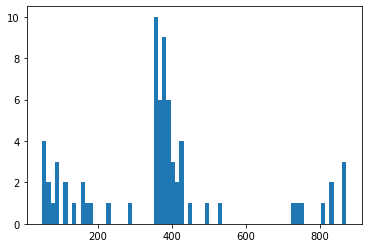

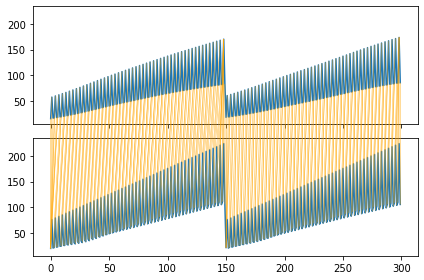

axis: Y


100%|██████████| 71/71 [04:32<00:00,  3.84s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


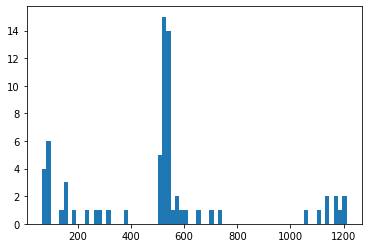

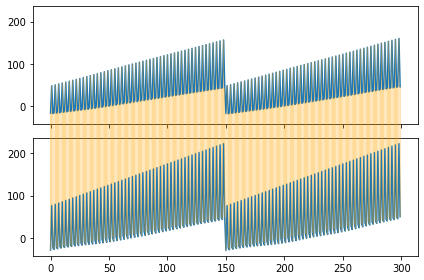

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 71/71 [05:17<00:00,  4.48s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


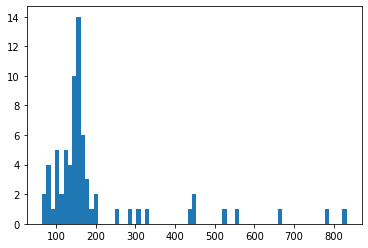

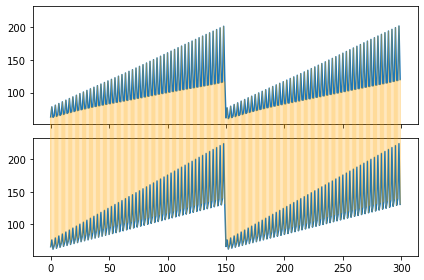

In [100]:

normative_lateral_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\lateral\RightJA_1Start_Cross.txt", sep = '\t')
stroke_lateral_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\lateral\RightJA_1Start_Cross.txt", sep = '\t')



lateral_R_df, result_lateral_R, norm_dist_lateral_R = main(normative_lateral_R, stroke_lateral_R, LATERAL, analyse_dict_R, ROM_dict, data_point, 'lateral R')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\3519033272.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: mouth R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 68/68 [01:39<00:00,  1.46s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


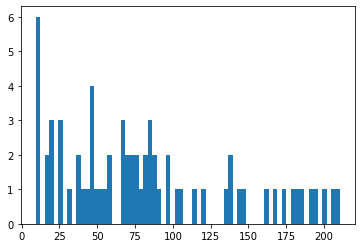

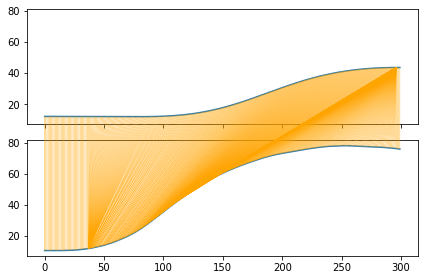

axis: Y


100%|██████████| 68/68 [01:37<00:00,  1.44s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


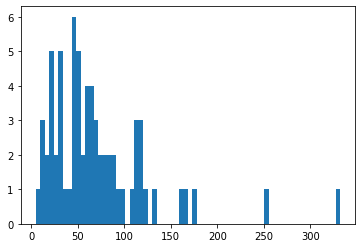

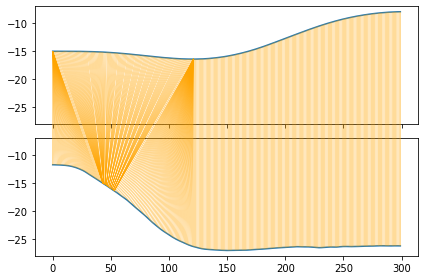

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


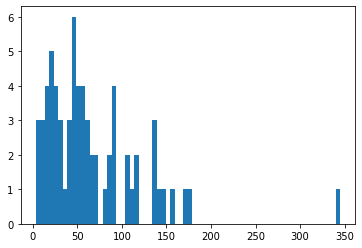

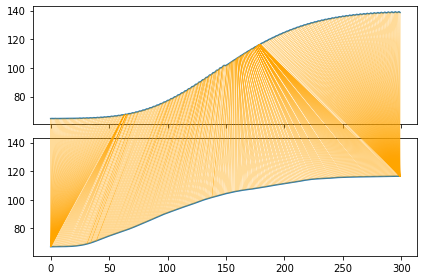

axis: Z


100%|██████████| 68/68 [01:36<00:00,  1.42s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


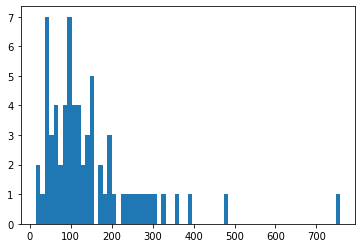

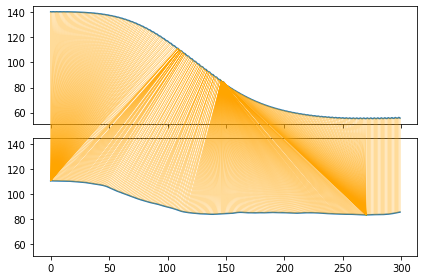

joint angle: R_Wrist_JOINT_ANGLE
axis: X


100%|██████████| 68/68 [01:39<00:00,  1.47s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


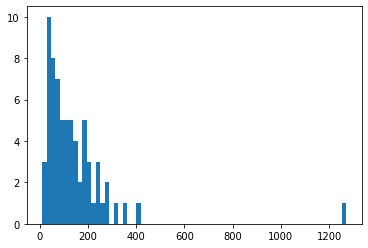

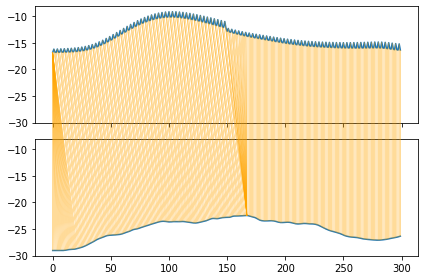

In [67]:
normative_mouth_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\mouth\RightJA_1Start_Mouth.txt", sep = '\t') # input
stroke_mouth_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\mouth\RightJA_1Start_Mouth.txt", sep = '\t')

mouth_R_df, result_mouth_R, norm_dist_mouth_R = main(normative_mouth_R, stroke_mouth_R, MOUTH, analyse_dict_R, ROM_dict, data_point, 'mouth R')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2958809469.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: key R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [01:26<00:00,  1.32s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


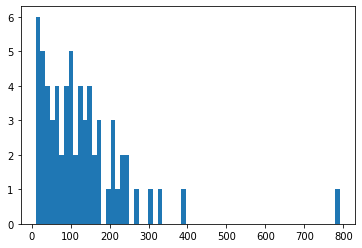

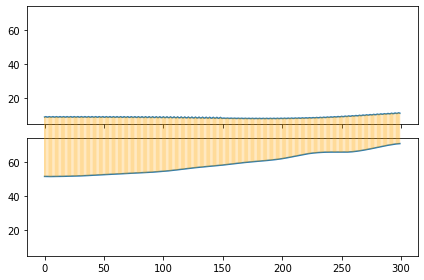

axis: Y


100%|██████████| 65/65 [01:32<00:00,  1.43s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


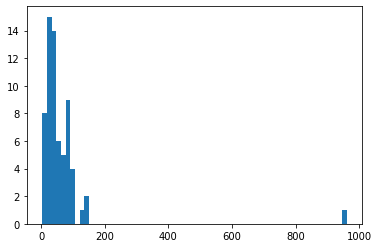

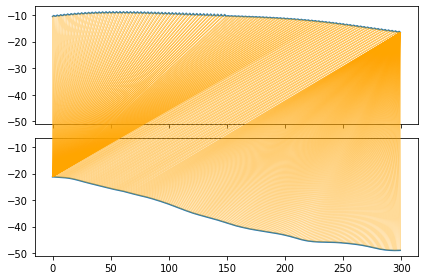

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [01:41<00:00,  1.56s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


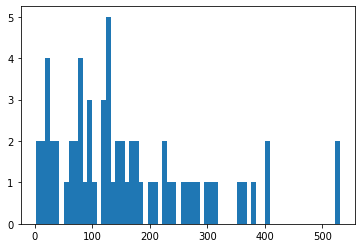

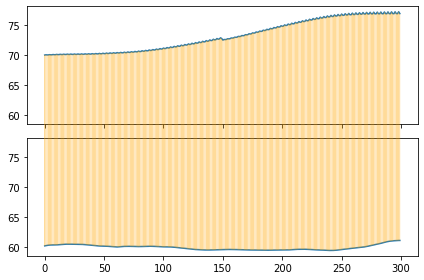

axis: Z


100%|██████████| 65/65 [01:38<00:00,  1.52s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


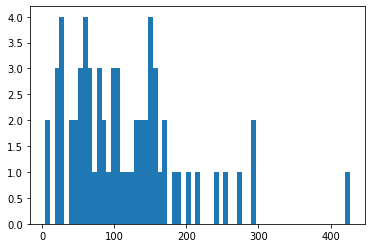

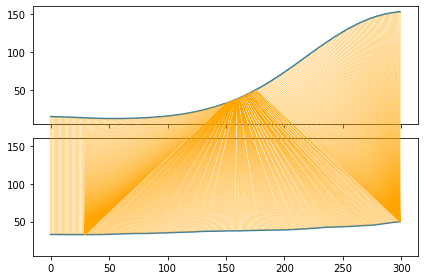

In [106]:



normative_key_back_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\key\RightJA_3Turn_Return.txt", sep = '\t')
stroke_key_back_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\RightJA_3Turn_Return.txt", sep = '\t')

key_back_R_df, result_key_back_R, norm_dist_key_back_R = main(normative_key_back_R, stroke_key_back_R, KEY, analyse_dict_R, ROM_dict, data_point, 'key R')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2456054693.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

Starting for Task: key R
joint angle: R_Shoulder_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [01:15<00:00,  1.16s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


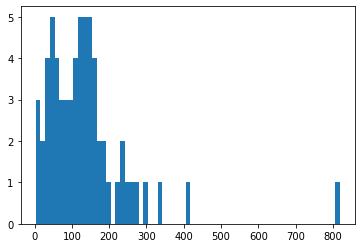

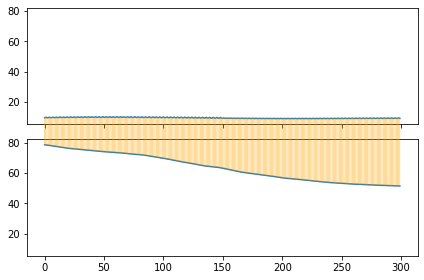

axis: Y


100%|██████████| 65/65 [01:18<00:00,  1.20s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


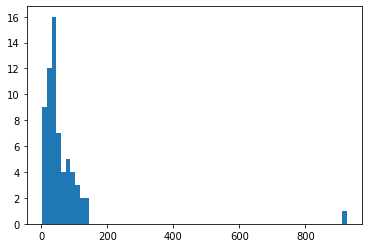

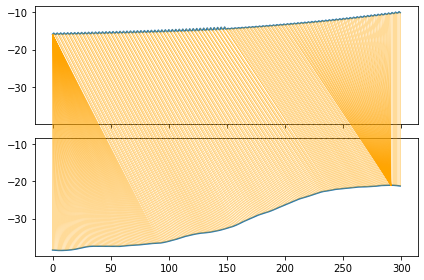

joint angle: R_Elbow_JOINT_ANGLE
axis: X


100%|██████████| 65/65 [01:33<00:00,  1.43s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


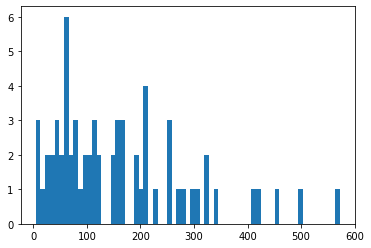

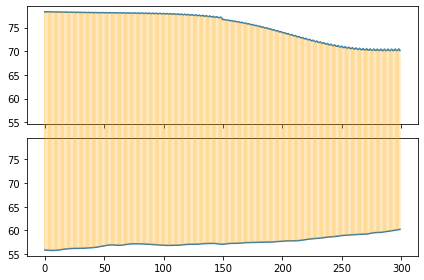

axis: Z


100%|██████████| 65/65 [01:23<00:00,  1.28s/it]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\5311547.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  confidence = st.t.interval(alpha=0.95, df=len(normal_dist_data)-1, loc=np.mean(normal_dist_data), scale=st.sem(normal_dist_data))


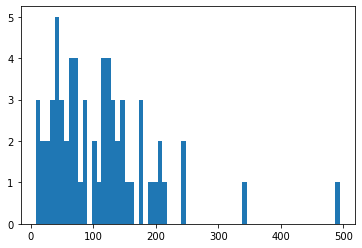

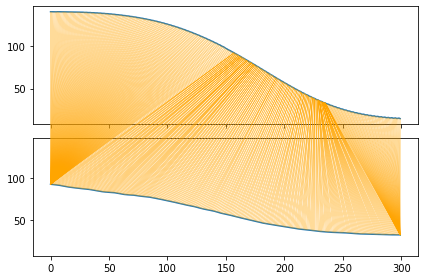

In [97]:


normative_key_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\Normative\1. EXPORTS\key\RightJA_2Touchkey_Turn.txt", sep = '\t')
stroke_key_R = pd.read_csv(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Miscellaneous\BCI002\PATIENT_EXPORT\RightJA_2Touchkey_Turn.txt", sep = '\t')

key_R_df, result_key_R, norm_dist_key_R = main(normative_key_R, stroke_key_R, KEY, analyse_dict_R, ROM_dict, data_point, 'key R')

In [9]:
def main(normative_df, stroke_df, task, analyse_dict, ROM_dict, data_point, name):
    data, subject_list, subject_marker_dict, repetition_dict = manipulate_data(normative_df, stroke = False)
    stroke_data, stroke_list, stroke_marker_dict, stroke_repetition_dict = manipulate_data(stroke_df, stroke = True)

    print("Starting for Task:", name)
    total_index = 0
    for key in task.keys():
        total_index = total_index + len(task[key])*len(analyse_dict[key])


    # consolidate end results
    feature_dict = get_feature_dict(analyse_dict, task)
    result = pd.DataFrame(columns = ['Joint Angle', 'Feature', 'Stroke Patient Score', 'Normative Confidence Interval'], index = [i for i in range(total_index)])
    rotation = {"X":"Flexion/Extension", "Y":"Abduction/Adduction", "Z":"External/Internal Rotation"}
    current_index = -1


    normal_dist_data = collections.defaultdict()

    feature_dict = get_feature_dict(analyse_dict, task)

    for each_feature in feature_dict.keys():
        print("joint angle:", each_feature)
        for each_axis in feature_dict[each_feature]:
            print("axis:", each_axis)
            current_index += 1
            analysing = rotation[each_axis]

            # do bootstraping to get normal distribution, confidence interval, dtw score for each point to analyse and each axis
            normative_JA, normative_JA_mean, normative_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, subject_list, repetition_dict, subject_marker_dict)
            stroke_JA, stroke_JA_mean, stroke_n_sample = get_joint_angle_dict(stroke_data, data_point, each_feature, each_axis, stroke_list, stroke_repetition_dict, stroke_marker_dict)
            normal_dist_list = []
            for subject in tqdm(subject_list):
                individual_subject_list = [subject]
                bootstrap_subject_list = [ x for x in subject_list if x != subject]
                bootstrap_JA, bootstrap_JA_mean, bootstrap_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, bootstrap_subject_list, repetition_dict, subject_marker_dict)
                individual_JA, individual_JA_mean, individual_n_sample = get_joint_angle_dict(data, data_point, each_feature, each_axis, individual_subject_list, repetition_dict, subject_marker_dict)
                individual_score = generate_score(bootstrap_JA_mean, individual_JA_mean)
                normal_dist_list.append(float(individual_score))
            confidence_interval = generate_norm_dist(normal_dist_list, show_graph=True)
            stroke_score = generate_score(normative_JA_mean, stroke_JA_mean, plot_graph = True)

            each_row = {}
            each_row["Joint Angle"] = each_feature
            each_row["Feature"] = analysing
            each_row["Stroke Patient Score"] = stroke_score
            each_row["Normative Confidence Interval"] = confidence_interval
            normal_dist_data['normative_'+str(each_feature) + '_' + str(each_axis)] = normal_dist_list
            normal_dist_data['stroke_'+str(each_feature)+'_'+str(each_axis)] = stroke_score

            sd = np.std(np.array(normal_dist_data['normative_'+str(each_feature) + '_' + str(each_axis)]))
            each_row["std of normative"] = sd

            mean = np.mean(np.array(normal_dist_data['normative_'+str(each_feature) + '_' + str(each_axis)]))
            each_row["mean of normative"] = mean

            temp_list = normal_dist_data['normative_'+str(each_feature) + '_' + str(each_axis)] + [normal_dist_data['stroke_'+str(each_feature)+'_'+str(each_axis)]]
            zscore_list = stats.zscore(temp_list)
            each_row["stroke z-score"] = zscore_list[-1]
            result.loc[current_index] = pd.Series(each_row)

    return data, result, normal_dist_data

    # except:
    #     print("error at running the main calculation")
    #     data = None
    #     result =  None
    #     normal_dist_data = None
    #     return data, result, normal_dist_data


In [87]:
def upper_threshold(result_df):
    upper_threshold_list = []
    for index in range(len(result_df)):
        if (int(result_df["Stroke Patient Score"][index]) > result_df["Normative Confidence Interval"][index][0]) == True and (int(result_df["Stroke Patient Score"][index]) < result_df["Normative Confidence Interval"][index][1]) == True:
            upper_threshold_list.append(1)
            # result_df["Drop (Upper threshold)"][index] = 1
        else:
            upper_threshold_list.append(0)
            # result_df["Drop (Upper threshold)"][index] = 0
    result_df["Drop (Upper threshold)"] = upper_threshold_list
    return result_df

def get_norm_dist(results, normal_dist_data):
    mean_list = []
    sd_list = []
    zscore_list = []
    for index in range(len(results)):
        if results["Feature"][index] == "Flexion/Extension":
            axis = "X"
        elif results["Feature"][index] == "Abduction/Adduction":
            axis = "Y"
        elif results["Feature"][index] == "External/Internal Rotation":
            axis = "Z"
            
        mean = np.mean(np.array(normal_dist_data['normative_'+str(results["Joint Angle"][index]) + '_' + str(axis)]))
        mean_list.append(mean)
        sd = np.std(np.array(normal_dist_data['normative_'+str(results["Joint Angle"][index]) + '_' + str(axis)]))
        sd_list.append(sd)
        zscores = (normal_dist_data['stroke_'+str(results["Joint Angle"][index]) + '_' + str(axis)] - mean) / sd
        zscore_list.append(zscores)

    results["Normative Mean"] = mean_list
    results["Normative SD"] = sd_list
    results["Stroke Z-Score"] = zscore_list

    return results



def get_trial_ROM(df, feature_dict, first_result):
    df["feature"] = df["markers"] + '_'+ df["axis"]

    features_list = [i+'_'+j for i, k in feature_dict.items() for j in k]
    relevant_df = df[df["feature"].isin(features_list)]
    trial_rom_list = []
    # print(relevant_df)
    for i in range(len(relevant_df)):
        trial_rom_list.append(max([float(k) for k in relevant_df.iloc[i,5:-1]]) - min([float(k) for k in relevant_df.iloc[i,5:-1]]))
        # print(trial_ROM)
    # test.iloc[:,4:-1]
    relevant_df["trial ROM"] = trial_rom_list
    average_list = collections.defaultdict()
    for feature in features_list:
        average_list[feature] = mean(relevant_df["trial ROM"][relevant_df["feature"] == feature])
    resorted_average_list = []
    for i in range(len(first_result)):
        if first_result["Feature"][i] == "Flexion/Extension":
            axis = "X"
        if first_result["Feature"][i] == "Abduction/Adduction":
            axis = "Y"
        if first_result["Feature"][i] == "External/Internal Rotation":
            axis = "Z"
        resorted_average_list.append(average_list[first_result["Joint Angle"][i] + '_' + axis])
    first_result["Trial ROM"] = resorted_average_list
    return relevant_df, features_list, first_result

def get_significance_vector(result_table, feature_dict, analyse_dict, ROM_dict):
    significancy_list = []
    rom_list = []
    total_calculation = []
    result_table = result_table.reset_index()
    for index in range(len(result_table)):
        for each_axis in feature_dict[result_table["Joint Angle"][index]]:
            for i, k in analyse_dict.items():
                if result_table["Joint Angle"][index] in k:
                    rangeOfMotion = tuple((i, each_axis))
                    break
        rom_list.append(ROM_dict[rangeOfMotion])
        significancy = (result_table["Trial ROM"][index]) / (int(ROM_dict[rangeOfMotion][1]) - int(ROM_dict[rangeOfMotion][0]))
        significancy_list.append(float(significancy))
    # print(significancy_list)
    result_table["ROM"] = rom_list
    result_table["weight"] = significancy_list

    
    return result_table

In [107]:
second_result_towel_vert_R = upper_threshold(result_towel_vert_R)
second_result_towel_hori_R = upper_threshold(result_towel_hori_R)
second_result_grasp_R = upper_threshold(result_grasp_R)
second_result_lateral_R = upper_threshold(result_lateral_R)

second_result_mouth_R = upper_threshold(result_mouth_R)

second_result_key_R = upper_threshold(result_key_R)
second_result_key_back_R = upper_threshold(result_key_back_R)


In [120]:
second_result_key_back_R


,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold)
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,876.895382,"(101.81313213236483, 160.4419949808239)",0
1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,423.007958,"(35.16207339358235, 93.3270434143304)",0
2,R_Elbow_JOINT_ANGLE,Flexion/Extension,234.862685,"(129.4298514673817, 191.48765957266056)",0
3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,791.221842,"(94.85585442232619, 134.5787215915342)",0


In [108]:
feature_dict_towel_vert_R = get_feature_dict(analyse_dict_R, TOWEL_vertFold)
relevant_towel_vert_R_df, towel_vert_R_feature_list, second_result_towel_vert_R = get_trial_ROM(towelvert_R_df, feature_dict_towel_vert_R, result_towel_vert_R)
third_result_towel_vert_R = get_significance_vector(second_result_towel_vert_R, feature_dict_towel_vert_R, analyse_dict_R, ROM_dict)

feature_dict_towel_hori_R = get_feature_dict(analyse_dict_R, TOWEL_horiFold)
relevant_towel_hori_R_df, towel_hori_R_feature_list, second_result_towel_hori_R = get_trial_ROM(towelhori_R_df, feature_dict_towel_hori_R, result_towel_hori_R)
third_result_towel_hori_R = get_significance_vector(second_result_towel_hori_R, feature_dict_towel_hori_R, analyse_dict_R, ROM_dict)

feature_dict_grasp_R = get_feature_dict(analyse_dict_R, GRASP)
relevant_grasp_R_df, grasp_R_feature_list, second_result_grasp_R = get_trial_ROM(grasp_R_df, feature_dict_grasp_R, result_grasp_R)
third_result_grasp_R = get_significance_vector(second_result_grasp_R, feature_dict_grasp_R, analyse_dict_R, ROM_dict)

feature_dict_lateral_R = get_feature_dict(analyse_dict_R, LATERAL)
relevant_lateral_R_df, lateral_R_feature_list, second_result_lateral_R = get_trial_ROM(lateral_R_df, feature_dict_lateral_R, result_lateral_R)
third_result_lateral_R = get_significance_vector(second_result_lateral_R, feature_dict_lateral_R, analyse_dict_R, ROM_dict)

feature_dict_mouth_R = get_feature_dict(analyse_dict_R, MOUTH)
relevant_mouth_R_df, mouth_R_feature_list, second_result_mouth_R = get_trial_ROM(mouth_R_df, feature_dict_mouth_R, result_mouth_R)
third_result_mouth_R = get_significance_vector(second_result_mouth_R, feature_dict_mouth_R, analyse_dict_R, ROM_dict)

feature_dict_key_R = get_feature_dict(analyse_dict_R, KEY)
relevant_key_R_df, key_R_feature_list, second_result_key_R = get_trial_ROM(key_R_df, feature_dict_key_R, result_key_R)
third_result_key_R = get_significance_vector(second_result_key_R, feature_dict_key_R, analyse_dict_R, ROM_dict)

feature_dict_key_back_R = get_feature_dict(analyse_dict_R, KEY)
relevant_key_back_R_df, key_back_R_feature_list, second_result_key_back_R = get_trial_ROM(key_back_R_df, feature_dict_key_R, result_key_R)
third_result_key_back_R = get_significance_vector(second_result_key_back_R, feature_dict_key_back_R, analyse_dict_R, ROM_dict)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2971995994.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df["trial ROM"] = trial_rom_list
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2971995994.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df["trial ROM"] = trial_rom_list
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27228\2971995994.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [114]:
third_result_key_back_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,951.170775,"(105.68914190417178, 164.66128832014203)",0,3.464873,"(-180, 50)",0.015065,131.127564,117.390985,6.352854
1,1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,299.304357,"(36.15263604439476, 92.41639195283153)",0,8.217687,"(-180, 50)",0.035729,64.244558,116.462145,3.080515
2,2,R_Elbow_JOINT_ANGLE,Flexion/Extension,316.798157,"(128.12790600051056, 191.37128659710288)",0,8.208590,"(-80, 80)",0.051304,160.458756,124.256669,0.598792
3,3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,480.894587,"(88.99661688769712, 130.2244813251318)",0,140.918798,"(-80, 80)",0.880742,114.717288,79.536021,8.505637


In [109]:
fourth_result_towel_vert_R = get_norm_dist(third_result_towel_vert_R, norm_dist_towel_vert_R)
fourth_result_towel_hori_R = get_norm_dist(third_result_towel_hori_R, norm_dist_towel_hori_R)
fourth_result_grasp_R = get_norm_dist(third_result_grasp_R, norm_dist_grasp_R)
fourth_result_lateral_R = get_norm_dist(third_result_lateral_R, norm_dist_lateral_R)

fourth_result_mouth_R = get_norm_dist(third_result_mouth_R, norm_dist_mouth_R)

fourth_result_key_R = get_norm_dist(third_result_key_R, norm_dist_key_R)

fourth_result_key_back_R = get_norm_dist(third_result_key_back_R, norm_dist_key_back_R)


In [124]:
fourth_result_grasp_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,54.406187,"(97.71980419357091, 146.46659316265598)",0,78.647235,"(-50, 180)",0.341945,122.093199,101.486797,-0.666954
1,1,R_Elbow_JOINT_ANGLE,Flexion/Extension,129.977074,"(95.3269362948285, 155.07210349816472)",1,59.890643,"(0, 140)",0.427790,125.199520,124.384514,0.038410
2,2,R_Wrist_JOINT_ANGLE,Flexion/Extension,339.616729,"(203.62686135447348, 304.0849482111435)",0,15.916712,"(-60, 60)",0.132639,253.855905,209.145457,0.410053


In [127]:
def total_score(towel_vert_result, towel_hori_result, grasp_result, lateral_result, mouth_result, key_result, key_back_result):
    final_score_dict = collections.defaultdict() 
    final_score_towel_vert = sum(towel_vert_result["weight"] * abs(towel_vert_result["Stroke Z-Score"]))
    final_score_dict["Moving Towel"] = final_score_towel_vert
    final_score_towel_hori = sum(towel_hori_result["weight"] * abs(towel_hori_result["Stroke Z-Score"]))
    final_score_dict["Picking Block"] = final_score_towel_hori
    final_score_grasp = sum(grasp_result["weight"] * abs(grasp_result["Stroke Z-Score"]))
    final_score_dict["Shelving Items"] = final_score_grasp
    final_score_lateral = sum(lateral_result["weight"] * abs(lateral_result["Stroke Z-Score"]))
    final_score_dict["Scanning Goods"] = final_score_lateral
    final_score_mouth = sum(mouth_result["weight"] * abs(mouth_result["Stroke Z-Score"]))
    final_score_dict["Eating"] = final_score_mouth
    final_score_key = sum(key_result["weight"] * abs(key_result["Stroke Z-Score"]))
    final_score_dict["Pouring Drinks Part1"] = final_score_key
    final_score_key_back = sum(key_back_result["weight"] * abs(key_back_result["Stroke Z-Score"]))
    final_score_dict["Pouring Drinks Part2"] = final_score_key_back
    

    descending_final_score_dict = OrderedDict(sorted(final_score_dict.items(), key=lambda item: item[1], reverse=False))
    return descending_final_score_dict


In [128]:
final_results = total_score(fourth_result_towel_vert_R, fourth_result_towel_hori_R, fourth_result_grasp_R, fourth_result_lateral_R, fourth_result_mouth_R, fourth_result_mouth_R, fourth_result_key_back_R)

In [129]:
final_results

OrderedDict([('Scanning Goods', 0.06334579298902232),
             ('Shelving Items', 0.29888163650076394),
             ('Picking Block', 0.5691385932798428),
             ('Moving Towel', 0.743317930198494),
             ('Eating', 2.956395188563867),
             ('Pouring Drinks Part1', 2.956395188563867),
             ('Pouring Drinks Part2', 7.727764025464455)])

In [94]:
forpickle = [towelvert_R_df, result_towel_vert_R, norm_dist_towel_vert_R, 

towelhori_R_df, result_towel_hori_R, norm_dist_towel_hori_R,

grasp_R_df, result_grasp_R, norm_dist_grasp_R,

lateral_R_df, result_lateral_R, norm_dist_lateral_R,

mouth_R_df, result_mouth_R, norm_dist_mouth_R ,

key_R_df, result_key_R, norm_dist_key_R ]

In [95]:
pickle_out = open(r"Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Processed\models\BCI002_result.pickle","wb")
pickle.dump(forpickle, pickle_out)
pickle_out.close()

In [13]:
file = open('Z:\DataCollection\BCISoftRoboticsGloveIntervention\Stroke\Processed\models\BCI002_result.pickle', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()




NameError: name 'towelvert_R_df' is not defined

In [6]:
load_data = collections.defaultdict()

In [29]:
for i in range(len(forpickle)):
    if forpickle[i][0:4] == 'norm':
        load_data[forpickle[i]] = data[i]
    else:
        load_data[forpickle[i]] = pd.DataFrame(data[i])


In [42]:
towelvert_R_df = load_data['towelvert_R_df']
towelhori_R_df = load_data['towelhori_R_df']
grasp_R_df = load_data['grasp_R_df']
lateral_R_df = load_data['lateral_R_df']
mouth_R_df = load_data['mouth_R_df']
key_R_df = load_data['key_R_df']

In [39]:
result_towel_vert_R = load_data['result_towel_vert_R']
result_towel_hori_R = load_data['result_towel_hori_R']
result_grasp_R = load_data['result_grasp_R']
result_lateral_R = load_data['result_lateral_R']
result_mouth_R = load_data['result_mouth_R']
result_key_R = load_data['result_key_R']

In [44]:
norm_dist_towel_vert_R = load_data['norm_dist_towel_vert_R']
norm_dist_towel_hori_R = load_data['norm_dist_towel_hori_R']
norm_dist_grasp_R = load_data['norm_dist_grasp_R']
norm_dist_lateral_R = load_data['norm_dist_lateral_R']
norm_dist_mouth_R = load_data['norm_dist_mouth_R']
norm_dist_key_R = load_data['norm_dist_key_R']

In [62]:
second_result_towel_vert_R = upper_threshold(result_towel_vert_R)
second_result_towel_hori_R = upper_threshold(result_towel_hori_R)
second_result_grasp_R = upper_threshold(result_grasp_R)
second_result_lateral_R = upper_threshold(result_lateral_R)

second_result_mouth_R = upper_threshold(result_mouth_R)

second_result_key_R = upper_threshold(result_key_R)

In [63]:
feature_dict_towel_vert_R = get_feature_dict(analyse_dict_R, TOWEL_vertFold)
relevant_towel_vert_R_df, towel_vert_R_feature_list, second_result_towel_vert_R = get_trial_ROM(towelvert_R_df, feature_dict_towel_vert_R, result_towel_vert_R)
third_result_towel_vert_R = get_significance_vector(second_result_towel_vert_R, feature_dict_towel_vert_R, analyse_dict_R, ROM_dict)

feature_dict_towel_hori_R = get_feature_dict(analyse_dict_R, TOWEL_horiFold)
relevant_towel_hori_R_df, towel_hori_R_feature_list, second_result_towel_hori_R = get_trial_ROM(towelhori_R_df, feature_dict_towel_hori_R, result_towel_hori_R)
third_result_towel_hori_R = get_significance_vector(second_result_towel_hori_R, feature_dict_towel_hori_R, analyse_dict_R, ROM_dict)

feature_dict_grasp_R = get_feature_dict(analyse_dict_R, GRASP)
relevant_grasp_R_df, grasp_R_feature_list, second_result_grasp_R = get_trial_ROM(grasp_R_df, feature_dict_grasp_R, result_grasp_R)
third_result_grasp_R = get_significance_vector(second_result_grasp_R, feature_dict_grasp_R, analyse_dict_R, ROM_dict)

feature_dict_lateral_R = get_feature_dict(analyse_dict_R, LATERAL)
relevant_lateral_R_df, lateral_R_feature_list, second_result_lateral_R = get_trial_ROM(lateral_R_df, feature_dict_lateral_R, result_lateral_R)
third_result_lateral_R = get_significance_vector(second_result_lateral_R, feature_dict_lateral_R, analyse_dict_R, ROM_dict)

feature_dict_mouth_R = get_feature_dict(analyse_dict_R, MOUTH)
relevant_mouth_R_df, mouth_R_feature_list, second_result_mouth_R = get_trial_ROM(mouth_R_df, feature_dict_mouth_R, result_mouth_R)
third_result_mouth_R = get_significance_vector(second_result_mouth_R, feature_dict_mouth_R, analyse_dict_R, ROM_dict)

feature_dict_key_R = get_feature_dict(analyse_dict_R, KEY)
relevant_key_R_df, key_R_feature_list, second_result_key_R = get_trial_ROM(key_R_df, feature_dict_key_R, result_key_R)
third_result_key_R = get_significance_vector(second_result_key_R, feature_dict_key_R, analyse_dict_R, ROM_dict)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11612\3148919282.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df["trial ROM"] = trial_rom_list
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11612\3148919282.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df["trial ROM"] = trial_rom_list
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11612\3148919282.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [64]:
fourth_result_towel_vert_R = get_norm_dist(third_result_towel_vert_R, norm_dist_towel_vert_R)
fourth_result_towel_hori_R = get_norm_dist(third_result_towel_hori_R, norm_dist_towel_hori_R)
fourth_result_grasp_R = get_norm_dist(third_result_grasp_R, norm_dist_grasp_R)
fourth_result_lateral_R = get_norm_dist(third_result_lateral_R, norm_dist_lateral_R)

fourth_result_mouth_R = get_norm_dist(third_result_mouth_R, norm_dist_mouth_R)

fourth_result_key_R = get_norm_dist(third_result_key_R, norm_dist_key_R)

In [69]:
final_results = total_score(fourth_result_towel_vert_R, fourth_result_towel_hori_R, fourth_result_grasp_R, fourth_result_lateral_R, fourth_result_mouth_R, fourth_result_mouth_R)
final_results

OrderedDict([('Picking Block', 0.6217166928892461),
             ('Moving Towel', 1.8761610189646178),
             ('Shelving Items', 3.0219394522899714),
             ('Scanning Goods', 3.800415376964108),
             ('Eating', 4.2052873937803446),
             ('Pouring Drinks', 4.2052873937803446)])

Picking Block', 0.6012477803994194),
             ('Moving Towel', 1.8761610189646178),
             ('Shelving Items', 3.0219394522899714),
             ('Scanning Goods', 3.800415376964108),
             ('Eating', 4.2052873937803446),
             ('Pouring Drinks', 4.2052873937803446)]

#NOTE:
dont drop the joint angle, only drop if everything passes the normative band (the whole action)

# Picking Block

##### 1. Upper Threshold (Meet Normative Band)

In [70]:
second_result_towel_hori_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,107.055635,"(62.3163363631262, 167.12202091012347)",1,31.558990
1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,439.641522,"(31.35063890485658, 167.18235494014766)",0,26.232062
2,R_Elbow_JOINT_ANGLE,Flexion/Extension,364.85691,"(71.99701359605321, 143.67835038012583)",0,30.163941
3,R_Wrist_JOINT_ANGLE,Flexion/Extension,231.608046,"(101.86383965250542, 253.6300973606683)",1,15.575298


##### 2. Lower Threshold

In [71]:
fourth_result_towel_hori_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,107.055635,"(62.3163363631262, 167.12202091012347)",1,31.558990,"(-180, 50)",0.137213,114.719179,184.482523,-0.041541
1,1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,439.641522,"(31.35063890485658, 167.18235494014766)",0,26.232062,"(-180, 50)",0.114052,99.266497,239.095596,1.423594
2,2,R_Elbow_JOINT_ANGLE,Flexion/Extension,364.85691,"(71.99701359605321, 143.67835038012583)",0,30.163941,"(0, 140)",0.215457,107.837682,126.175922,2.036991
3,3,R_Wrist_JOINT_ANGLE,Flexion/Extension,231.608046,"(101.86383965250542, 253.6300973606683)",1,15.575298,"(-60, 60)",0.129794,177.746969,267.144117,0.201618


# Moving Towel

##### 1. Upper Threshold

In [51]:
second_result_towel_vert_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Trial ROM,Drop (Upper threshold)
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,220.433361,"(33.158478750659455, 142.74346862990348)",54.503035,0
1,R_Elbow_JOINT_ANGLE,Flexion/Extension,579.796379,"(42.710250789875786, 106.52498220188617)",55.035373,0
2,R_Wrist_JOINT_ANGLE,Flexion/Extension,271.090325,"(98.47583020459722, 233.86220745854393)",16.386324,0


##### 2. Lower Threshold

In [52]:
fourth_result_towel_vert_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Trial ROM,Drop (Upper threshold),ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,220.433361,"(33.158478750659455, 142.74346862990348)",54.503035,0,"(-50, 180)",0.236970,87.950974,204.683083,0.647256
1,1,R_Elbow_JOINT_ANGLE,Flexion/Extension,579.796379,"(42.710250789875786, 106.52498220188617)",55.035373,0,"(0, 140)",0.393110,74.617616,119.193295,4.238315
2,2,R_Wrist_JOINT_ANGLE,Flexion/Extension,271.090325,"(98.47583020459722, 233.86220745854393)",16.386324,0,"(-60, 60)",0.136553,166.169019,252.874971,0.414914


# Shelving Items

##### 1. Upper Threshold

In [53]:
second_result_grasp_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Normative Mean,Normative SD,Stroke Z-Score,Drop (Upper threshold),Trial ROM
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,457.070002,"(70.266951205847, 125.72046491274912)",97.993708,103.576194,[3.4667840180877207],0,76.790746
1,R_Elbow_JOINT_ANGLE,Flexion/Extension,641.313831,"(74.91468883931682, 147.72354122536566)",111.319115,135.992533,[3.897233930914154],0,57.964819
2,R_Wrist_JOINT_ANGLE,Flexion/Extension,552.890893,"(216.60583338658932, 300.6026358140475)",258.604235,156.889411,[1.875758577818198],0,16.050180


##### 2. Lower Threshold

In [54]:
fourth_result_grasp_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Normative Mean,Normative SD,Stroke Z-Score,Drop (Upper threshold),Trial ROM,ROM,weight
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,457.070002,"(70.266951205847, 125.72046491274912)",97.993708,103.576194,3.466784,0,76.790746,"(-50, 180)",0.333873
1,1,R_Elbow_JOINT_ANGLE,Flexion/Extension,641.313831,"(74.91468883931682, 147.72354122536566)",111.319115,135.992533,3.897234,0,57.964819,"(0, 140)",0.414034
2,2,R_Wrist_JOINT_ANGLE,Flexion/Extension,552.890893,"(216.60583338658932, 300.6026358140475)",258.604235,156.889411,1.875759,0,16.050180,"(-60, 60)",0.133752


# Scanning Goods

##### 1. Upper Threshold

In [55]:
second_result_lateral_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,44.879062,"(61.20589865739277, 91.14285764888739)",0,41.723978
1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,436.644106,"(44.472051566965256, 60.73347004120222)",0,22.513315
2,R_Elbow_JOINT_ANGLE,Flexion/Extension,534.324116,"(60.51477651128577, 89.89703522365977)",0,45.761240


##### 2. Lower Threshold

In [56]:
fourth_result_lateral_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,44.879062,"(61.20589865739277, 91.14285764888739)",0,41.723978,"(-180, 50)",0.181409,76.174378,56.949367,-0.549529
1,1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,436.644106,"(44.472051566965256, 60.73347004120222)",0,22.513315,"(-180, 50)",0.097884,52.602761,30.934254,12.414760
2,2,R_Elbow_JOINT_ANGLE,Flexion/Extension,534.324116,"(60.51477651128577, 89.89703522365977)",0,45.761240,"(0, 140)",0.326866,75.205906,55.894155,8.214065


# Eating

##### 1. Upper Threshold

In [57]:
second_result_mouth_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,38.070146,"(68.79013449446767, 97.42903220412556)",0,31.939363
1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,344.624732,"(59.009771022994535, 85.61156437336031)",0,10.191333
2,R_Elbow_JOINT_ANGLE,Flexion/Extension,318.215491,"(59.21025536982168, 90.23094976886892)",0,70.323472
3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,477.994687,"(111.44152994133981, 164.04127412488305)",0,91.730517
4,R_Wrist_JOINT_ANGLE,Flexion/Extension,467.9359,"(94.60162911300094, 185.54440358069652)",0,15.338998


##### 2. Lower Threshold

In [58]:
fourth_result_mouth_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,38.070146,"(68.79013449446767, 97.42903220412556)",0,31.939363,"(-180, 50)",0.138867,83.109583,53.491796,-0.841988
1,1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,344.624732,"(59.009771022994535, 85.61156437336031)",0,10.191333,"(-180, 50)",0.044310,72.310668,49.686888,5.480602
2,2,R_Elbow_JOINT_ANGLE,Flexion/Extension,318.215491,"(59.21025536982168, 90.23094976886892)",0,70.323472,"(-80, 80)",0.439522,74.720603,57.940521,4.202497
3,3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,477.994687,"(111.44152994133981, 164.04127412488305)",0,91.730517,"(-80, 80)",0.573316,137.741402,98.245917,3.463282
4,4,R_Wrist_JOINT_ANGLE,Flexion/Extension,467.9359,"(94.60162911300094, 185.54440358069652)",0,15.338998,"(-60, 60)",0.127825,140.073016,169.863113,1.930159


# Pouring Drinks

##### 1. Upper Threshold

In [59]:
second_result_key_R

,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM
0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,639.597818,"(81.2358286336372, 136.03850675196404)",0,2.016744
1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,513.700996,"(41.62002552688662, 85.62888242238256)",0,5.599722
2,R_Elbow_JOINT_ANGLE,Flexion/Extension,542.169139,"(157.77947671729547, 238.6326882893181)",0,9.323468
3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,1056.260784,"(77.06671051387644, 319.53136129515053)",0,128.085953


##### 2. Lower Threshold

In [60]:
fourth_result_key_R

,index,Joint Angle,Feature,Stroke Patient Score,Normative Confidence Interval,Drop (Upper threshold),Trial ROM,ROM,weight,Normative Mean,Normative SD,Stroke Z-Score
0,0,R_Shoulder_JOINT_ANGLE,Flexion/Extension,639.597818,"(81.2358286336372, 136.03850675196404)",0,2.016744,"(-180, 50)",0.008768,108.637168,95.447720,5.562843
1,1,R_Shoulder_JOINT_ANGLE,Abduction/Adduction,513.700996,"(41.62002552688662, 85.62888242238256)",0,5.599722,"(-180, 50)",0.024347,63.624454,76.648536,5.871952
2,2,R_Elbow_JOINT_ANGLE,Flexion/Extension,542.169139,"(157.77947671729547, 238.6326882893181)",0,9.323468,"(-80, 80)",0.058272,198.206083,140.818933,2.442591
3,3,R_Elbow_JOINT_ANGLE,External/Internal Rotation,1056.260784,"(77.06671051387644, 319.53136129515053)",0,128.085953,"(-80, 80)",0.800537,198.299036,422.291369,2.031682
